# Importing Libraries

* InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation. 
* StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product. 
* Description: Product (item) name. Nominal. 
* Quantity: The quantities of each product (item) per transaction. Numeric.	
* InvoiceDate: Invice date and time. Numeric. The day and time when a transaction was generated. 
* UnitPrice: Unit price. Numeric. Product price per unit in sterling (Â£). 
* CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer. 
* Country: Country name. Nominal. The name of the country where a customer resides.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [2]:
dataset = pd.read_excel('online_retail_II.xlsx')

In [3]:
dataset.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


# Exploring Data

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


We can see that Customer ID has fewer entries than the other columns, and we can also observe that InvoiceDate is already in datetime format, which is great.

In [5]:
dataset.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,525461.000000,525461,525461.000000,417534.000000
mean,10.337667,2010-06-28 11:37:36.845017856,4.688834,15360.645478
min,-9600.000000,2009-12-01 07:45:00,-53594.360000,12346.000000
25%,1.000000,2010-03-21 12:20:00,1.250000,13983.000000
50%,3.000000,2010-07-06 09:51:00,2.100000,15311.000000
75%,10.000000,2010-10-15 12:45:00,4.210000,16799.000000
max,19152.000000,2010-12-09 20:01:00,25111.090000,18287.000000
std,107.424110,NaN,146.126914,1680.811316


It looks weird that in Price and Quantity, we see some high negative values.

Let's go back and check why there is a difference between the quantity of Customer ID and the other columns.

In [6]:
dataset[dataset['Customer ID'].isna()]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.00,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.00,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.00,NaN,United Kingdom
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.00,NaN,United Kingdom
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
525231,538159,21324,NaN,-18,2010-12-09 17:17:00,0.00,NaN,United Kingdom
525232,538158,20892,NaN,-32,2010-12-09 17:17:00,0.00,NaN,United Kingdom
525233,538160,20956,NaN,288,2010-12-09 17:18:00,0.00,NaN,United Kingdom
525234,538161,46000S,Dotcom sales,-100,2010-12-09 17:25:00,0.00,NaN,United Kingdom


We can see that a lot of rows are missing a Customer ID, and in these rows, we can see that they have some negative values in quantity, and the price is zero or close to zero. Let's check this more in depth.

In [7]:
dataset[dataset['Price'] <= 0].sample(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
70039,495604,84288B,NaN,5,2010-01-26 10:32:00,0.0,NaN,United Kingdom
264887,514994,22122,NaN,64,2010-07-07 14:52:00,0.0,NaN,United Kingdom
383710,526250,20943,NaN,33,2010-10-11 10:23:00,0.0,NaN,United Kingdom
221072,510872,90027A,NaN,-37,2010-06-04 09:56:00,0.0,NaN,United Kingdom
201674,508799,22456,NaN,-25,2010-05-18 12:47:00,0.0,NaN,United Kingdom
193992,507857,35968,NaN,-160,2010-05-11 14:53:00,0.0,NaN,United Kingdom
221091,510892,90003C,NaN,-6,2010-06-04 10:06:00,0.0,NaN,United Kingdom
120697,500910,79072,NaN,-40,2010-03-11 10:21:00,0.0,NaN,United Kingdom
404565,528116,22483,RED GINGHAM TEDDY BEAR,5,2010-10-20 14:25:00,0.0,NaN,United Kingdom
229192,511534,90084,NaN,2,2010-06-08 17:25:00,0.0,NaN,United Kingdom


It looks like a great part of the rows that have a price equal to or below zero also have Customer ID as NaN.

In [8]:
dataset[dataset['Quantity'] <= 0].sample(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
203,C489459,90003C,MIDNIGHT BLUE PAIR HEART HAIR SLIDE,-3,2009-12-01 10:44:00,3.75,17592.0,United Kingdom
129424,C501698,22192,BLUE DINER WALL CLOCK,-1,2010-03-18 19:17:00,8.50,14702.0,United Kingdom
511202,C537132,22761,CHEST 7 DRAWER MA CAMPAGNE,-2,2010-12-05 12:29:00,21.95,15221.0,United Kingdom
265368,C515014,M,Manual,-1,2010-07-07 16:32:00,1588.51,15581.0,United Kingdom
66162,495306,84933B,NaN,-8,2010-01-22 14:08:00,0.00,NaN,United Kingdom
1424,C489568,82483,WOOD 2 DRAWER CABINET WHITE FINISH,-1,2009-12-01 13:20:00,5.95,15005.0,United Kingdom
255844,C514094,85123A,WHITE HANGING HEART T-LIGHT HOLDER,-4,2010-06-30 12:14:00,2.95,14648.0,United Kingdom
315779,520083,22302,NaN,-317,2010-08-24 10:42:00,0.00,NaN,United Kingdom
320290,C520576,22139,RETRO SPOT TEA SET CERAMIC 11 PC,-3,2010-08-27 10:22:00,4.95,17649.0,United Kingdom
256502,C514142,22486,PLASMATRONIC LAMP,-4,2010-06-30 13:51:00,12.75,14492.0,United Kingdom


We have some data that have a quantity below or equal to zero and also have a Customer ID, which means these rows could be good data. However, we can also see that the invoice code starts with 'C,' which means a cancellation, so we should probably just drop that. But when I was looking for samples, I saw some weird StockCodes; I will check that later.

In [9]:
dataset["Invoice"] = dataset["Invoice"].astype("str")
dataset[dataset["Invoice"].str.match("^\\d{6}$") == False]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
...,...,...,...,...,...,...,...,...
524695,C538123,22956,36 FOIL HEART CAKE CASES,-2,2010-12-09 15:41:00,2.10,12605.0,Germany
524696,C538124,M,Manual,-4,2010-12-09 15:43:00,0.50,15329.0,United Kingdom
524697,C538124,22699,ROSES REGENCY TEACUP AND SAUCER,-1,2010-12-09 15:43:00,2.95,15329.0,United Kingdom
524698,C538124,22423,REGENCY CAKESTAND 3 TIER,-1,2010-12-09 15:43:00,12.75,15329.0,United Kingdom


That matches regex ^\\d{6}\$ we escape the \ and with another \ but that regex means that we want ^ in the start of string should follow six digits d{6} and nothing more $ so we are looking for rows that dont have these pattern, like that 538164 with six number nothing more nothing less when we use False, it means that everything except that patern with six number will appear

Now let's ignore the number and see what remains, like the letter C at the start.

In [10]:
dataset["Invoice"].str.replace("[0-9]", "", regex=True).unique()


array(['', 'C', 'A'], dtype=object)

We have some values with the letter A that the paper about the dataset doesn't talk about. Let's check.

In [11]:
dataset[dataset["Invoice"].str.startswith("A")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom


It was just some rows that also have a negative price and a NaN Customer ID; we will drop that.

In [12]:
dataset[(dataset["StockCode"].str.match("^\\d{5}$") == False)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
12,489436,48173C,DOOR MAT BLACK FLOCK,10,2009-12-01 09:06:00,5.95,13078.0,United Kingdom
23,489436,35004B,SET OF 3 BLACK FLYING DUCKS,12,2009-12-01 09:06:00,4.65,13078.0,United Kingdom
28,489436,84596F,SMALL MARSHMALLOWS PINK BOWL,8,2009-12-01 09:06:00,1.25,13078.0,United Kingdom
...,...,...,...,...,...,...,...,...
525387,538170,84029E,RED WOOLLY HOTTIE WHITE HEART.,2,2010-12-09 19:32:00,3.75,13969.0,United Kingdom
525388,538170,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,2,2010-12-09 19:32:00,3.75,13969.0,United Kingdom
525389,538170,85232B,SET OF 3 BABUSHKA STACKING TINS,2,2010-12-09 19:32:00,4.95,13969.0,United Kingdom
525435,538171,47591D,PINK FAIRY CAKE CHILDRENS APRON,1,2010-12-09 20:01:00,1.95,17530.0,United Kingdom


Let's check the StockCode; we can see that the pattern is 5 digits, but we can also see that some of the StockCodes have letters at the end.

In [13]:
dataset["StockCode"] = dataset["StockCode"].astype("str")

In [14]:
dataset[(dataset["StockCode"].str.match("^\\d{5}$") == False) & (dataset["StockCode"].str.match("^\\d{5}[a-zA-Z]+$") == False)]["StockCode"].unique()


array(['POST', 'D', 'DCGS0058', 'DCGS0068', 'DOT', 'M', 'DCGS0004',
       'DCGS0076', 'C2', 'BANK CHARGES', 'DCGS0003', 'TEST001',
       'gift_0001_80', 'DCGS0072', 'gift_0001_20', 'DCGS0044', 'TEST002',
       'gift_0001_10', 'gift_0001_50', 'DCGS0066N', 'gift_0001_30',
       'PADS', 'ADJUST', 'gift_0001_40', 'gift_0001_60', 'gift_0001_70',
       'gift_0001_90', 'DCGSSGIRL', 'DCGS0006', 'DCGS0016', 'DCGS0027',
       'DCGS0036', 'DCGS0039', 'DCGS0060', 'DCGS0056', 'DCGS0059', 'GIFT',
       'DCGSLBOY', 'm', 'DCGS0053', 'DCGS0062', 'DCGS0037', 'DCGSSBOY',
       'DCGSLGIRL', 'S', 'DCGS0069', 'DCGS0070', 'DCGS0075', 'B',
       'DCGS0041', 'ADJUST2', '47503J ', 'C3', 'SP1002', 'AMAZONFEE'],
      dtype=object)

# Clean Dataset

In [15]:
dataset_clean = dataset.copy()

In [16]:
dataset_clean['Invoice'] = dataset_clean['Invoice'].astype("str")

mask = (
    dataset_clean['Invoice'].str.match("^\\d{6}$") == True
)

dataset_clean = dataset_clean[mask]

In [17]:
dataset_clean['StockCode'] = dataset_clean['StockCode'].astype("str")

mask = (
    dataset_clean['StockCode'].str.match("^\\d{5}$") == True
    |  (dataset_clean['StockCode'].str.match("^\\d{5}[a-zA-Z]+$") == True)
    |    (dataset_clean['StockCode'].str.match("^PADS$") == True)
)

dataset_clean = dataset_clean[mask]

In [18]:
dataset_clean.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,437330.000000,437330,437330.000000,350929.000000
mean,11.213411,2010-07-03 10:01:32.490796544,3.366328,15360.276233
min,-9600.000000,2009-12-01 07:45:00,0.000000,12346.000000
25%,1.000000,2010-03-28 11:02:00,1.250000,13985.000000
50%,4.000000,2010-07-15 11:08:00,2.100000,15311.000000
75%,12.000000,2010-10-18 14:07:00,4.210000,16797.000000
max,19152.000000,2010-12-09 20:01:00,1157.150000,18287.000000
std,109.002511,NaN,5.226608,1678.208380


We still have negative numbers in quantity and price with zero, but we haven't taken the step to clean the NaN Customer IDs. Let's do this now.

In [19]:
dataset_clean.dropna(subset=["Customer ID"], inplace=True)

In [20]:
dataset_clean.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,350929.000000,350929,350929.000000,350929.000000
mean,13.700113,2010-07-05 17:14:04.387041024,2.979683,15360.276233
min,1.000000,2009-12-01 07:45:00,0.000000,12346.000000
25%,2.000000,2010-03-31 17:29:00,1.250000,13985.000000
50%,5.000000,2010-07-18 13:42:00,1.950000,15311.000000
75%,12.000000,2010-10-17 14:26:00,3.750000,16797.000000
max,19152.000000,2010-12-09 20:01:00,295.000000,18287.000000
std,100.076779,NaN,4.424721,1678.208380


Ok now our Quantity is fixed without negative number but our price still has the zero

In [21]:
len(dataset_clean[dataset_clean["Price"] == 0])

27

We have some rows with a zero value in price but it's just 27 rows that we can drop

In [22]:
dataset_clean = dataset_clean[dataset_clean["Price"] > 0]

In [23]:
dataset_clean.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,350902.000000,350902,350902.000000,350902.000000
mean,13.700566,2010-07-05 17:18:45.468763136,2.979913,15360.384495
min,1.000000,2009-12-01 07:45:00,0.030000,12346.000000
25%,2.000000,2010-03-31 17:29:00,1.250000,13985.000000
50%,5.000000,2010-07-18 13:42:00,1.950000,15311.000000
75%,12.000000,2010-10-17 14:26:00,3.750000,16797.000000
max,19152.000000,2010-12-09 20:01:00,295.000000,18287.000000
std,100.080558,NaN,4.424814,1678.168412


Now our Price looks good, we still have values close to zero, but it looks good.

In [24]:
print(f'The cleasing drop {100 - len(dataset_clean)/ len(dataset)*100}%')

The cleasing drop 33.2201628665115%


# Feature Engineering

We can create new columns, like the total spent on an invoice, which should be Price multiplied by Quantity.

In [25]:
dataset_clean['TotalSales'] = dataset_clean['Quantity'] * dataset_clean['Price']

Now let's group by Customer ID and sum some features like Invoice; then we can see the frequency.

In [26]:
aggregated_df = dataset_clean.groupby(by="Customer ID", as_index=False) \
    .agg(
        MonetaryValue=("TotalSales", "sum"),
        Frequency=("Invoice", "nunique"),
        FirstInvoiceDate=("InvoiceDate", "min"),
        LastInvoiceDate=("InvoiceDate", "max")
    )

aggregated_df.head(5)

,Customer ID,MonetaryValue,Frequency,FirstInvoiceDate,LastInvoiceDate
0,12346.0,144.02,2,2010-03-02 13:08:00,2010-06-28 13:53:00
1,12347.0,966.87,2,2010-10-31 14:20:00,2010-12-07 14:57:00
2,12348.0,221.16,1,2010-09-27 14:59:00,2010-09-27 14:59:00
3,12349.0,1946.64,2,2010-04-29 13:20:00,2010-10-28 08:23:00
4,12351.0,300.93,1,2010-11-29 15:23:00,2010-11-29 15:23:00


Let's calculate Recency, which measures the time since a customer's last purchase. It is calculated by determining the number of days between the customer's last transaction and the most recent date in the dataset (in real-world scenarios with live data, this would typically be today's date). A lower Recency value indicates the customer made a purchase more recently, while a higher value means more time has passed since their last purchase.

In [27]:
max_invoice_date = aggregated_df["LastInvoiceDate"].max()

aggregated_df["Recency"] = (max_invoice_date - aggregated_df["LastInvoiceDate"]).dt.days

aggregated_df.head(5)

,Customer ID,MonetaryValue,Frequency,FirstInvoiceDate,LastInvoiceDate,Recency
0,12346.0,144.02,2,2010-03-02 13:08:00,2010-06-28 13:53:00,164
1,12347.0,966.87,2,2010-10-31 14:20:00,2010-12-07 14:57:00,2
2,12348.0,221.16,1,2010-09-27 14:59:00,2010-09-27 14:59:00,73
3,12349.0,1946.64,2,2010-04-29 13:20:00,2010-10-28 08:23:00,42
4,12351.0,300.93,1,2010-11-29 15:23:00,2010-11-29 15:23:00,10


Let's see the distribution of this new data.

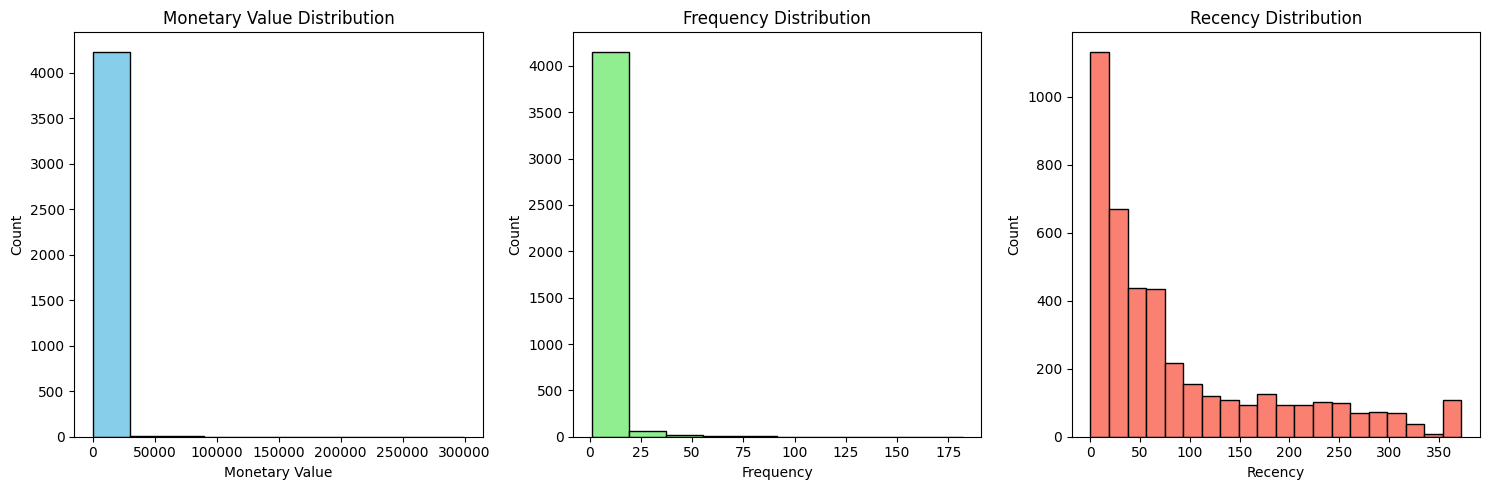

In [28]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(aggregated_df['MonetaryValue'], bins=10, color='skyblue', edgecolor='black')
plt.title('Monetary Value Distribution')
plt.xlabel('Monetary Value')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
plt.hist(aggregated_df['Frequency'], bins=10, color='lightgreen', edgecolor='black')
plt.title('Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
plt.hist(aggregated_df['Recency'], bins=20, color='salmon', edgecolor='black')
plt.title('Recency Distribution')
plt.xlabel('Recency')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

It looks like we have some outliers, let's check with a boxplot.

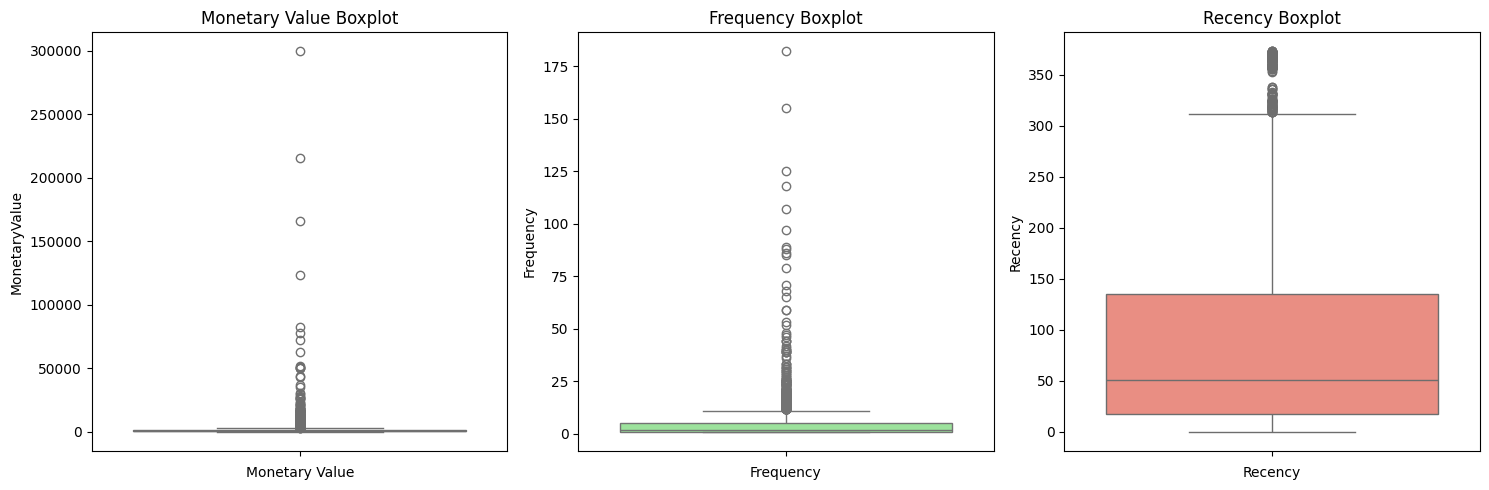

In [29]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(data=aggregated_df['MonetaryValue'], color='skyblue')
plt.title('Monetary Value Boxplot')
plt.xlabel('Monetary Value')

plt.subplot(1, 3, 2)
sns.boxplot(data=aggregated_df['Frequency'], color='lightgreen')
plt.title('Frequency Boxplot')
plt.xlabel('Frequency')

plt.subplot(1, 3, 3)
sns.boxplot(data=aggregated_df['Recency'], color='salmon')
plt.title('Recency Boxplot')
plt.xlabel('Recency')

plt.tight_layout()
plt.show()

In [30]:
aggregated_df.describe()

,Customer ID,MonetaryValue,Frequency,FirstInvoiceDate,LastInvoiceDate,Recency
count,4248.000000,4248.000000,4248.000000,4248,4248,4248.000000
mean,15353.896422,1728.337813,4.376412,2010-04-29 21:01:26.822033920,2010-09-11 03:14:47.161016832,89.417137
min,12346.000000,2.950000,1.000000,2009-12-01 07:45:00,2009-12-01 12:55:00,0.000000
25%,13888.750000,263.895000,1.000000,2010-01-15 12:03:45,2010-07-27 14:28:00,17.000000
50%,15358.500000,616.085000,2.000000,2010-04-01 14:13:30,2010-10-19 14:09:00,51.000000
75%,16836.500000,1478.380000,5.000000,2010-08-16 20:08:00,2010-11-22 12:04:15,135.000000
max,18287.000000,299485.800000,182.000000,2010-12-09 16:08:00,2010-12-09 20:01:00,373.000000
std,1699.238394,7530.991878,7.762138,NaN,NaN,96.377474


Let’s clean these extreme outlier values, but why not just remove these rows? Actually, these outliers represent customers who buy a lot and with high frequency; they are the most valuable customers. Therefore, we will separate the outliers that we can use in further analysis and keep this data separate from the model. We will use the interquartile calculation to identify these data points.

In [31]:
def calculate_outliers_iqr(df, cols):
    outliers_mask = pd.DataFrame(False, index=df.index, columns=cols)
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers_mask[col] = (df[col] < lower_bound) | (df[col] > upper_bound)
    return outliers_mask


In [32]:
columns_outliers = ['MonetaryValue', 'Frequency', 'Recency']
outliers_mask = calculate_outliers_iqr(aggregated_df,columns_outliers)

In [33]:
outliers = aggregated_df[outliers_mask.any(axis=1)]
outliers.describe()

,Customer ID,MonetaryValue,Frequency,FirstInvoiceDate,LastInvoiceDate,Recency
count,628.000000,628.000000,628.000000,628,628,628.000000
mean,15257.686306,7099.684809,12.705414,2010-01-11 13:37:47.484076544,2010-08-18 22:17:34.777070080,112.622611
min,12357.000000,2.950000,1.000000,2009-12-01 07:45:00,2009-12-01 12:55:00,0.000000
25%,13823.750000,807.502500,2.000000,2009-12-04 16:36:45,2010-01-27 15:28:00,7.000000
50%,15191.000000,3902.075000,10.000000,2009-12-13 15:53:30,2010-11-16 14:16:30,23.000000
75%,16748.000000,6404.965000,15.000000,2010-01-25 08:46:00,2010-12-02 18:38:15,316.000000
max,18260.000000,299485.800000,182.000000,2010-11-16 10:05:00,2010-12-09 19:32:00,373.000000
std,1722.084811,18635.255006,17.243842,NaN,NaN,148.257898


In [34]:
clean_outliers = aggregated_df[~outliers_mask.any(axis=1)]
clean_outliers.describe()

,Customer ID,MonetaryValue,Frequency,FirstInvoiceDate,LastInvoiceDate,Recency
count,3620.000000,3620.000000,3620.000000,3620,3620,3620.000000
mean,15370.587017,796.512975,2.931492,2010-05-18 15:58:07.524861952,2010-09-15 03:52:01.508287232,85.391436
min,12346.000000,3.750000,1.000000,2009-12-01 09:08:00,2010-01-31 12:19:00,0.000000
25%,13896.750000,250.522500,1.000000,2010-02-08 13:51:30,2010-08-02 14:12:30,21.000000
50%,15378.500000,535.505000,2.000000,2010-05-02 11:50:00,2010-10-15 13:49:00,55.000000
75%,16849.500000,1138.480000,4.000000,2010-09-14 14:57:00,2010-11-18 13:18:45,129.000000
max,18287.000000,3298.600000,11.000000,2010-12-09 16:08:00,2010-12-09 20:01:00,312.000000
std,1694.928260,718.882253,2.250112,NaN,NaN,83.562242


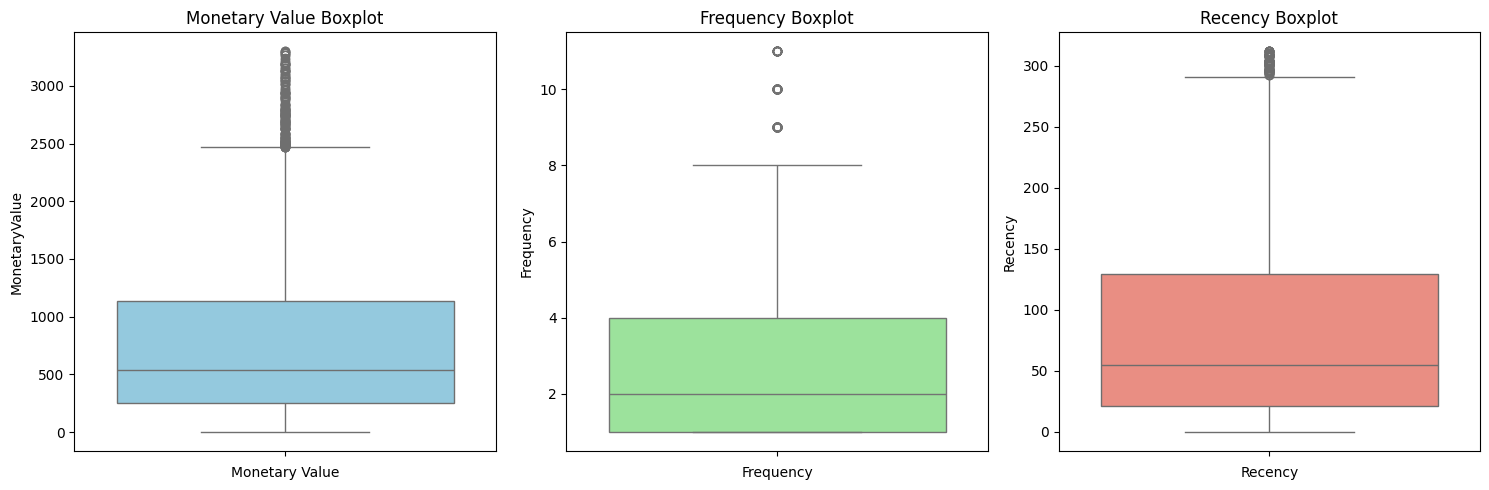

In [35]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(data=clean_outliers['MonetaryValue'], color='skyblue')
plt.title('Monetary Value Boxplot')
plt.xlabel('Monetary Value')

plt.subplot(1, 3, 2)
sns.boxplot(data=clean_outliers['Frequency'], color='lightgreen')
plt.title('Frequency Boxplot')
plt.xlabel('Frequency')

plt.subplot(1, 3, 3)
sns.boxplot(data=clean_outliers['Recency'], color='salmon')
plt.title('Recency Boxplot')
plt.xlabel('Recency')

plt.tight_layout()
plt.show()

We still have outliers, but now our boxplot is not squashed to the bottom.

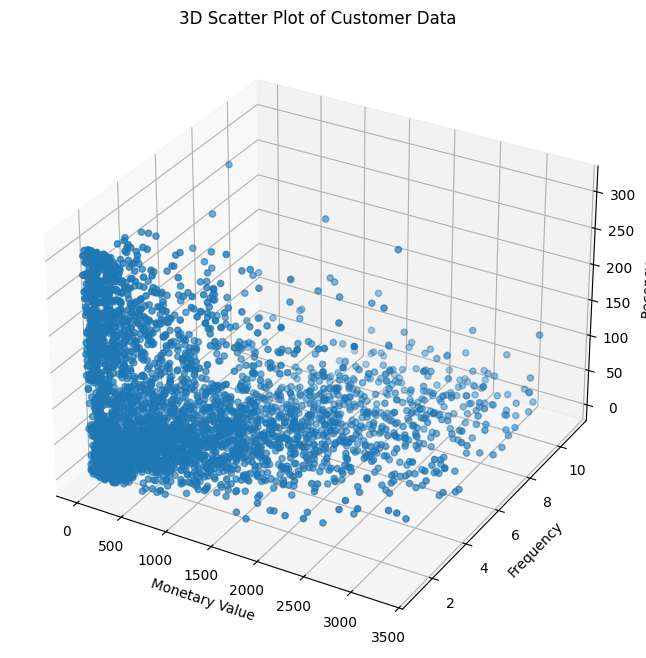

In [37]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(clean_outliers["MonetaryValue"], clean_outliers["Frequency"], clean_outliers["Recency"])

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3D Scatter Plot of Customer Data')

plt.show()

In [41]:
fig = px.scatter_3d(clean_outliers,
                    x='MonetaryValue',
                    y='Frequency',
                    z='Recency',
                    title='3D Scatter Plot of Customer Data',
                    labels={'MonetaryValue': 'Monetary Value', 
                            'Frequency': 'Frequency', 
                            'Recency': 'Recency'})

fig.update_traces(marker=dict(size=5))
fig.update_layout(
    width=800, 
    height=800  
)
fig.show()


Finally, we need to scale this data to the same range because the algorithm is sensitive to the scale. As you can see in the 3D graph, each feature has its own scale: Monetary Value is in the thousands, Frequency is in the tens, and Recency is in the hundreds. Therefore, we will use the StandardScaler.

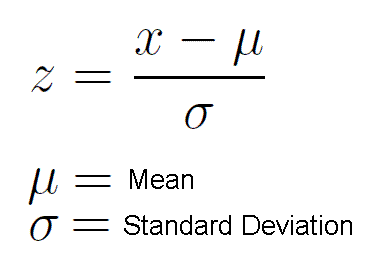

In [46]:
scaler = StandardScaler()

scaled_data = scaler.fit_transform(clean_outliers[['MonetaryValue', 'Frequency', 'Recency']])

In [47]:
scaled_data_df = pd.DataFrame(scaled_data, index=clean_outliers.index, columns=("MonetaryValue", "Frequency", "Recency"))

scaled_data_df

,MonetaryValue,Frequency,Recency
0,-0.907775,-0.414033,0.940849
1,0.237008,-0.414033,-0.998094
2,-0.800454,-0.858517,-0.148310
3,1.600103,-0.414033,-0.519343
4,-0.689475,-0.858517,-0.902344
...,...,...,...
4243,-0.324608,1.363902,-0.818562
4244,-0.563777,-0.858517,-0.232092
4245,-0.605764,-0.858517,2.508759
4246,0.211172,-0.414033,0.306503


Now let's plot the graphs again, and you will see that all the features are in the same scale.

In [104]:
cluster_colors = {
    0: '#1f77b4',  # Blue
    1: '#ff7f0e',  # Orange
    2: '#2ca02c',  # Green
    3: '#d62728'   # Red
}

clean_outliers['Color'] = clean_outliers['Cluster'].map(cluster_colors)

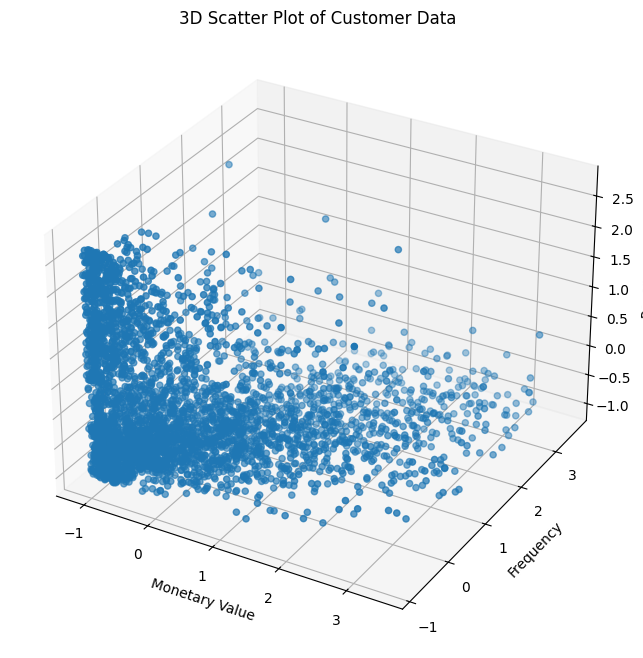

In [111]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(scaled_data_df["MonetaryValue"], scaled_data_df["Frequency"], scaled_data_df["Recency"])

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3D Scatter Plot of Customer Data')
color='Color'

plt.show()

In [112]:
fig = px.scatter_3d(clean_outliers,
                    x='MonetaryValue',
                    y='Frequency',
                    z='Recency',
                    title='3D Scatter Plot of Customer Data',
                    labels={'MonetaryValue': 'Monetary Value', 
                            'Frequency': 'Frequency', 
                            'Recency': 'Recency'})

fig.update_traces(marker=dict(size=5))
fig.update_layout(
    width=800, 
    height=800  
)
fig.show()


# Clustering

We will apply clustering in this data so we can find patterns.

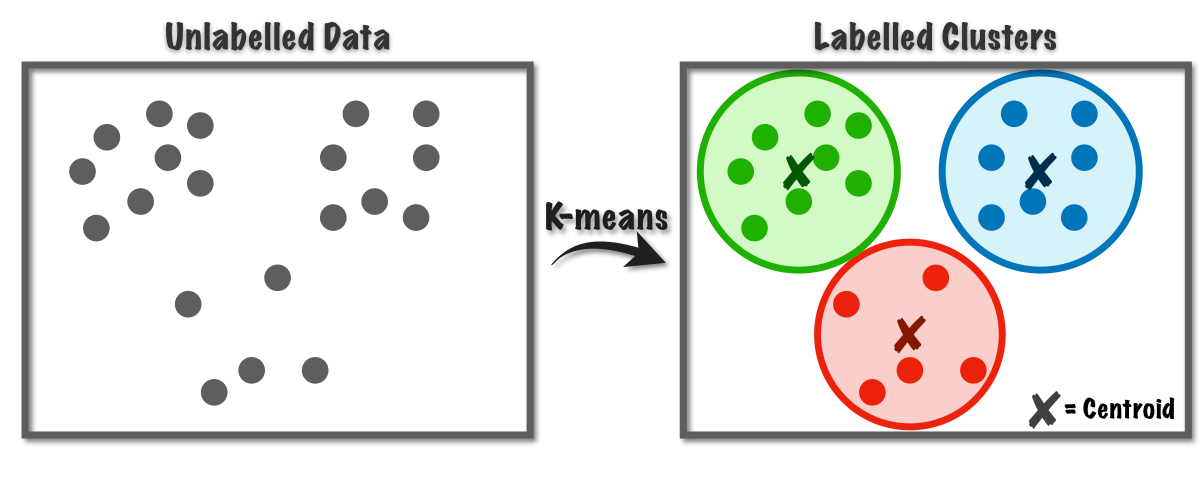

Let's use the Elbow technique to determine how many clusters we need, and we will also check the Silhouette Score.

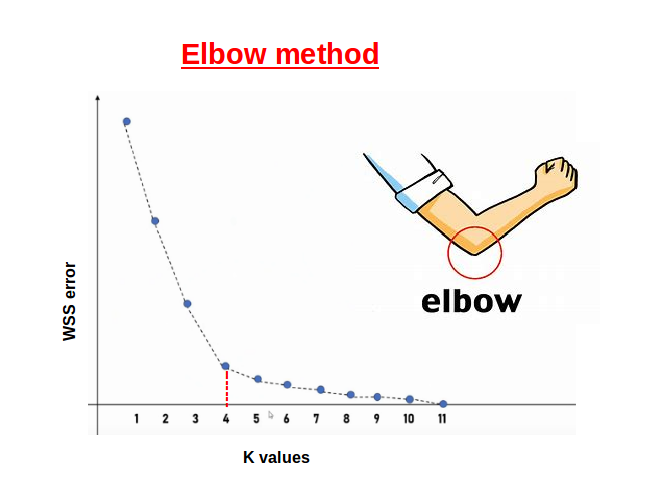

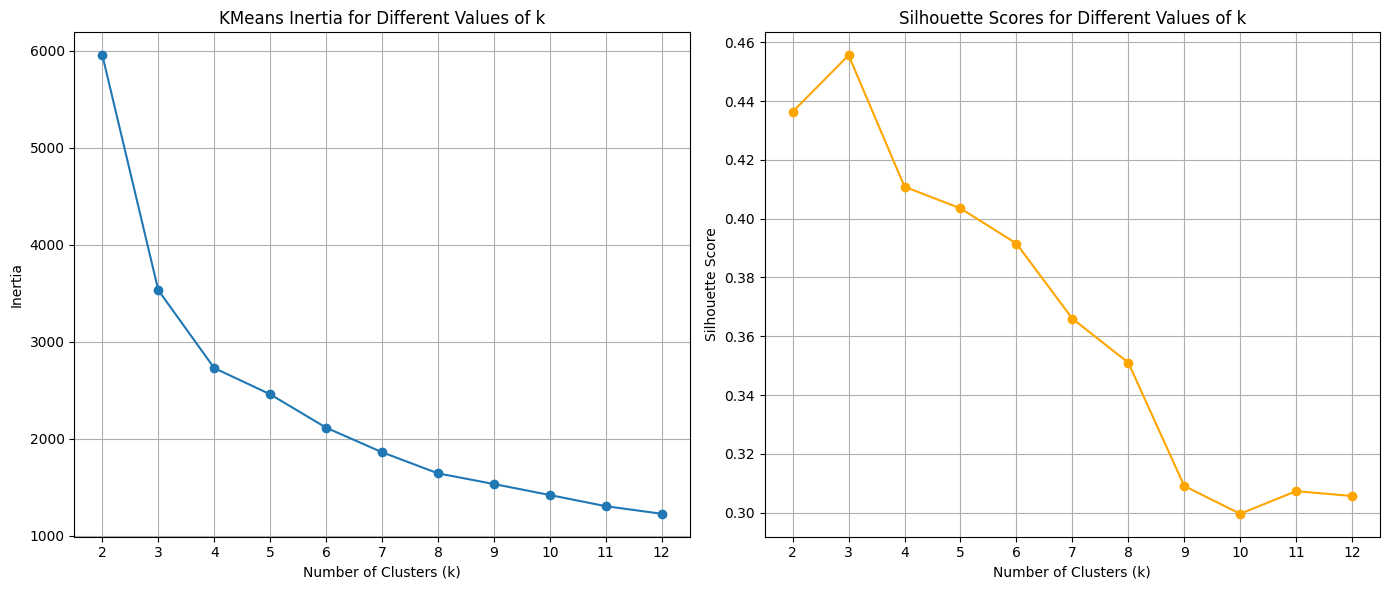

In [51]:
max_k = 12

inertia = []
silhoutte_scores = []
k_values = range(2, max_k + 1)

for k in k_values:

    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=166, max_iter=1000)

    cluster_labels = kmeans.fit_predict(scaled_data_df)

    sil_score = silhouette_score(scaled_data_df, cluster_labels)

    silhoutte_scores.append(sil_score)

    inertia.append(kmeans.inertia_)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o')
plt.title('KMeans Inertia for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)


plt.subplot(1, 2, 2)
plt.plot(k_values, silhoutte_scores, marker='o', color='orange')
plt.title('Silhouette Scores for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)


plt.tight_layout()
plt.show()

Our 'Elbow' indicates that the optimal number of clusters is between 4 and 6. Additionally, the Silhouette Score for these numbers suggests that four clusters provide a better score. Therefore, we should use four clusters for our problem.

In [91]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=166, max_iter=1000)

clusters_labels = kmeans.fit_predict(scaled_data_df)

len(clusters_labels)

3620

In [92]:
unique_labels = set(clusters_labels)
print(unique_labels)


{np.int32(0), np.int32(1), np.int32(2), np.int32(3)}


In [115]:
clean_outliers.loc[:, "Cluster"] = clusters_labels

clean_outliers


,Customer ID,MonetaryValue,Frequency,FirstInvoiceDate,LastInvoiceDate,Recency,Cluster
0,12346.0,144.02,2,2010-03-02 13:08:00,2010-06-28 13:53:00,164,2
1,12347.0,966.87,2,2010-10-31 14:20:00,2010-12-07 14:57:00,2,3
2,12348.0,221.16,1,2010-09-27 14:59:00,2010-09-27 14:59:00,73,3
3,12349.0,1946.64,2,2010-04-29 13:20:00,2010-10-28 08:23:00,42,0
4,12351.0,300.93,1,2010-11-29 15:23:00,2010-11-29 15:23:00,10,3
...,...,...,...,...,...,...,...
4243,18283.0,563.19,6,2010-02-19 17:16:00,2010-11-22 15:30:00,17,0
4244,18284.0,391.28,1,2010-10-04 11:33:00,2010-10-04 11:33:00,66,3
4245,18285.0,361.10,1,2010-02-17 10:24:00,2010-02-17 10:24:00,295,2
4246,18286.0,948.30,2,2009-12-16 10:45:00,2010-08-20 11:57:00,111,3


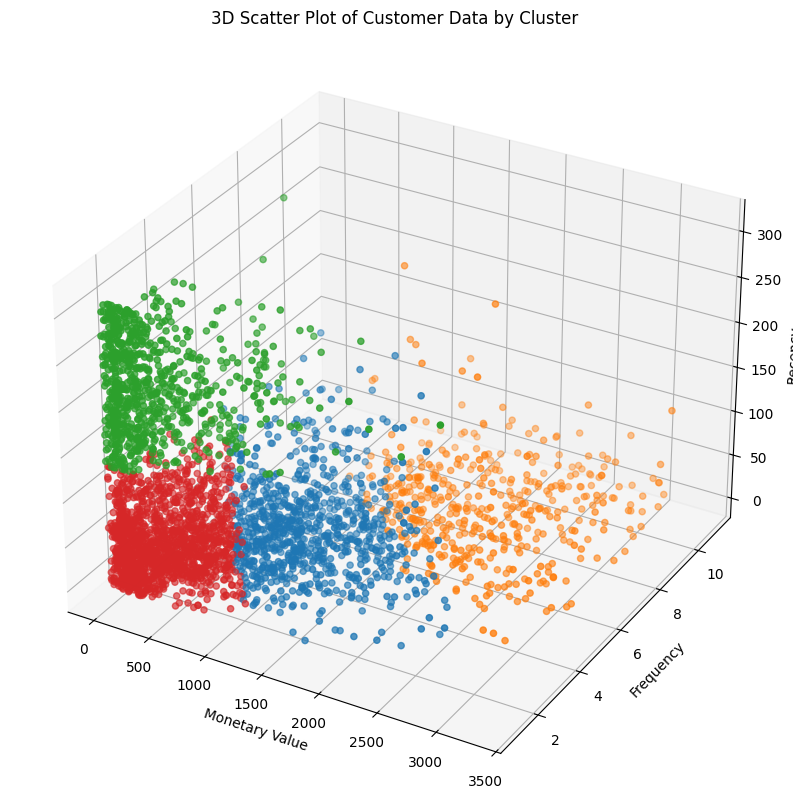

In [116]:
cluster_colors = {0: '#1f77b4',  # Blue
                  1: '#ff7f0e',  # Orange
                  2: '#2ca02c',  # Green
                  3: '#d62728'}  # Red

colors = clean_outliers['Cluster'].map(cluster_colors)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(clean_outliers['MonetaryValue'], 
                     clean_outliers['Frequency'], 
                     clean_outliers['Recency'], 
                     c=colors,  # Use mapped solid colors
                     marker='o')

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3D Scatter Plot of Customer Data by Cluster')

plt.show()

In [117]:
fig = px.scatter_3d(clean_outliers,
                     x='MonetaryValue',
                     y='Frequency',
                     z='Recency',
                     color=colors, 
                     title='3D Scatter Plot of Customer Data by Cluster',
                     labels={'MonetaryValue': 'Monetary Value', 
                             'Frequency': 'Frequency', 
                             'Recency': 'Recency'})

fig.update_traces(marker=dict(size=5))
fig.update_layout(width=800, height=800)  
fig.show()

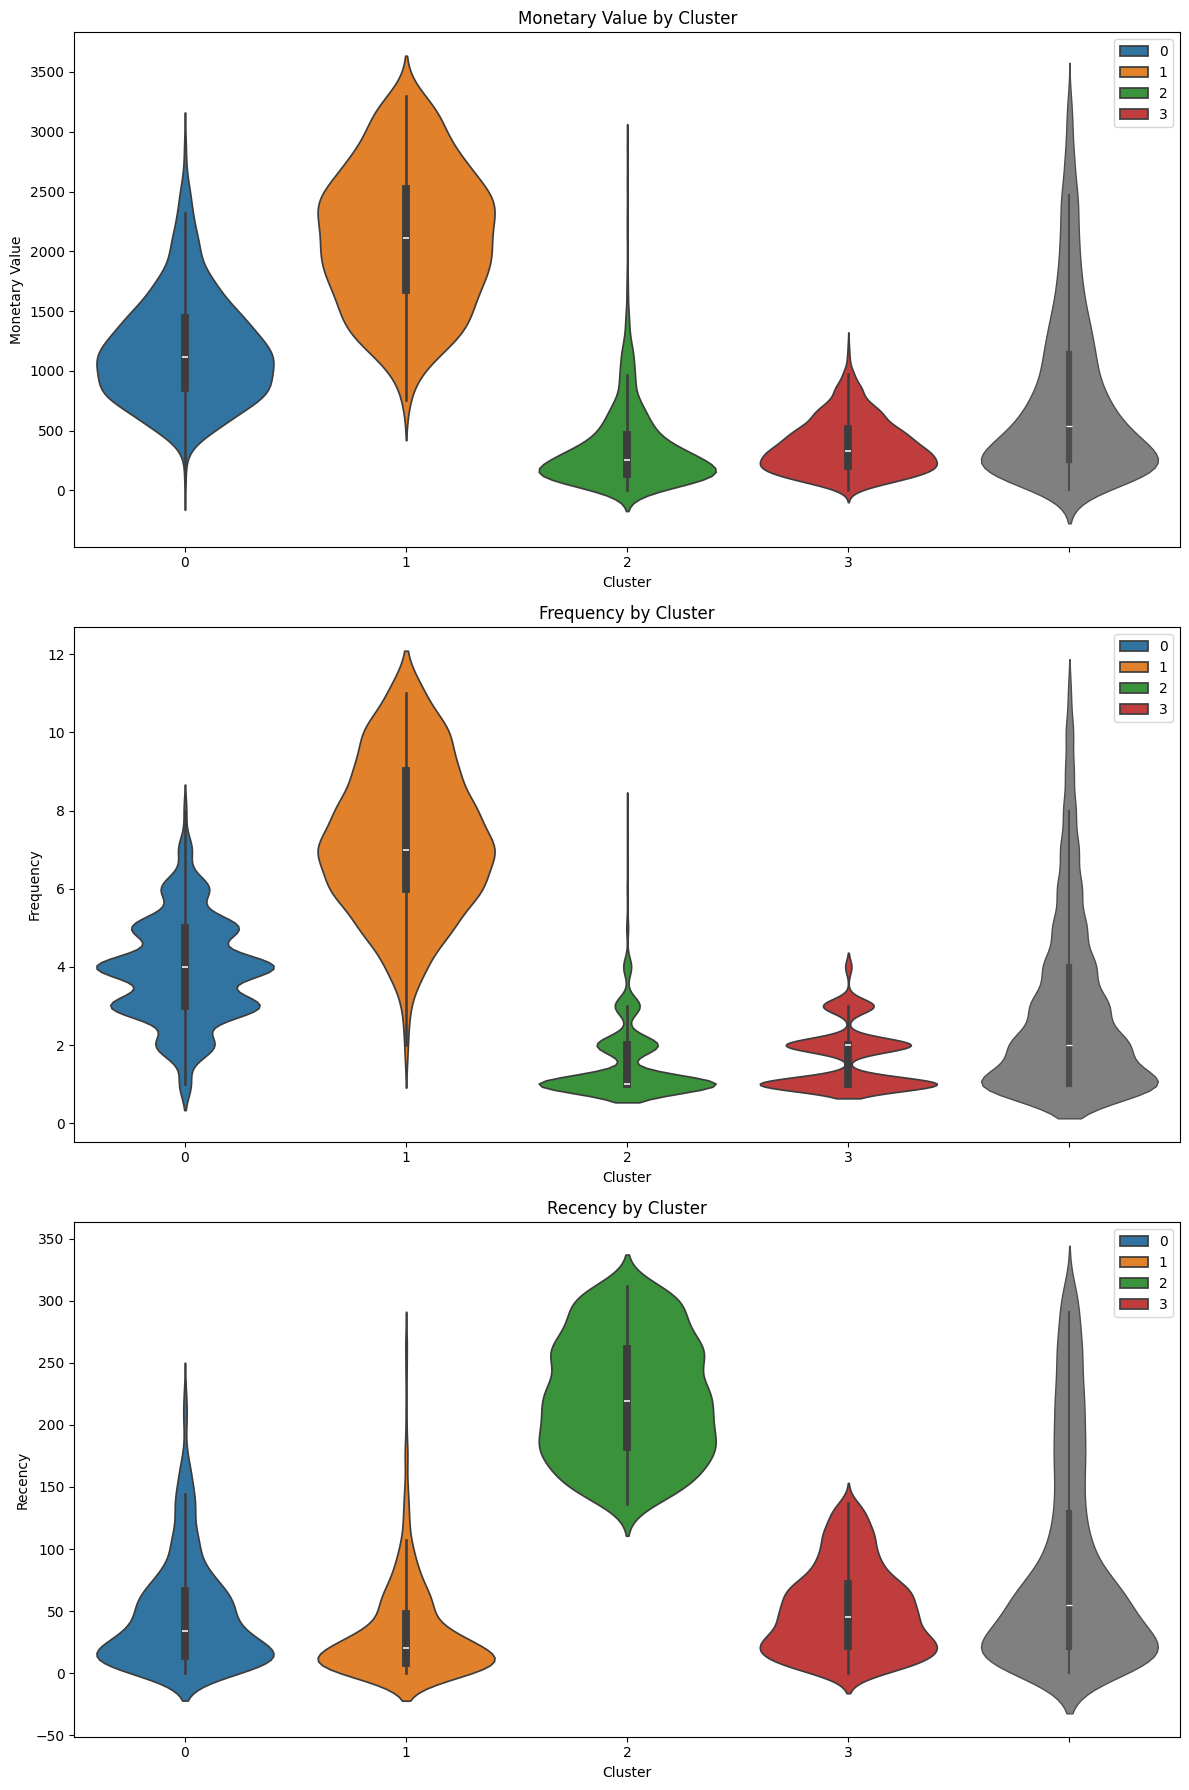

In [119]:
plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
sns.violinplot(x=clean_outliers['Cluster'], y=clean_outliers['MonetaryValue'], palette=cluster_colors, hue=clean_outliers["Cluster"])
sns.violinplot(y=clean_outliers['MonetaryValue'], color='gray', linewidth=1.0)
plt.title('Monetary Value by Cluster')
plt.ylabel('Monetary Value')

plt.subplot(3, 1, 2)
sns.violinplot(x=clean_outliers['Cluster'], y=clean_outliers['Frequency'], palette=cluster_colors, hue=clean_outliers["Cluster"])
sns.violinplot(y=clean_outliers['Frequency'], color='gray', linewidth=1.0)
plt.title('Frequency by Cluster')
plt.ylabel('Frequency')


plt.subplot(3, 1, 3)
sns.violinplot(x=clean_outliers['Cluster'], y=clean_outliers['Recency'], palette=cluster_colors, hue=clean_outliers["Cluster"])
sns.violinplot(y=clean_outliers['Recency'], color='gray', linewidth=1.0)
plt.title('Recency by Cluster')
plt.ylabel('Recency')

plt.tight_layout()
plt.show()

In [125]:
clean_outliers.groupby('Cluster')["MonetaryValue"].describe()


,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,887.0,1183.601860,449.038174,68.70,852.640,1118.64,1444.165,2931.04
1,473.0,2116.655962,578.594120,758.14,1675.280,2109.94,2521.270,3298.60
2,801.0,356.842347,335.709759,3.75,135.390,253.88,467.500,2887.92
3,1459.0,374.580624,221.642431,5.10,204.155,332.40,513.805,1218.72


In [124]:
clean_outliers.groupby('Cluster')["Frequency"].describe()


,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,887.0,3.917700,1.289387,1.0,3.0,4.0,5.0,8.0
1,473.0,7.295983,1.864341,2.0,6.0,7.0,9.0,11.0
2,801.0,1.538077,0.883946,1.0,1.0,1.0,2.0,8.0
3,1459.0,1.681974,0.776205,1.0,1.0,2.0,2.0,4.0


In [126]:
clean_outliers.groupby('Cluster')["Recency"].describe()


,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,887.0,46.983089,43.069223,0.0,14.0,34.0,66.0,228.0
1,473.0,32.843552,38.143308,0.0,8.0,20.0,48.0,269.0
2,801.0,222.027466,48.184948,136.0,182.0,219.0,261.0,312.0
3,1459.0,50.763537,34.786291,0.0,22.0,45.0,72.0,137.0


Lets Analyze our Cluster we will check the violion plots that are without scale, and also the tables that show us the data scaled.

Blue(0):
* Has the second highest mean of Monetary value
* Has the second highest mean of Frequency
* has the third highest mean of Recency but its very closed with the second
* And if we analyze the violins plot this means that this cluster represent high-value customer that spends a lot, with the second highest mean of Frequency but the distribuiton is crazy, but not very recently they are old good customer
Action: Use targeted marketing campaigns, special discounts, or reminders to encourage them to return and purchase again.

Orange(1):
* Has the highest mean of Monetary value
* Has the highest mean of Frequency
* has the lowest mean of Recency
* This cluster represents the customer that expends a lot and with high frequency also they are recently customers
Action: Personalized Offers, Loyalt Programs and regular engagament to ensury that they will remain active

Green(2):
* Has the lowest mean of Monetary value
* Has the lowest mean of Frequency but its very closed with the third one
* has the highest mean of Recency
* These customers have the highest mean of Recency, indicating they are older customers. However, their purchase frequency is low, and they have the lowest monetary value, making them less desirable customers.
Action: Implement reengagement strategies, such as personalized marketing campaigns and incentives, to encourage these customers to make more frequent purchases.

Red(3):
* Has the second lowest mean of Monetary value
* Has the second lowest mean of Frequency but its very closed with the lowest
* has the second highest mean of Recency but its very closed with the third and fourth
* This cluster may indicate a category of customers who, are not so older, are not active in terms of spending, which could raise concerns about retention.
 Action: Focus on customer retention strategies, such as loyalty programs and targeted communication, to motivate these customers to increase their engagement (frequency) and spending.